In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import griddata
import scipy.interpolate as inter
import sys, time, timeit
from streamplot import streamplot
import read as read
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import copy
from scipy import interpolate
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import amrplot
import pickle
import numpy_support as ah
import math
from scipy.optimize import fsolve
import pandas as pd

In [2]:
#path='../tracer/out_madfm_hres/'
path='../tracer/mad_ideal_refine_3/'

offset=400

In [3]:
#d1=read.load(0, file=path+'data',type='vtu', silent=1);
d2=read.load(offset, file=path+'data',type='vtu', silent=1);


In [4]:
class MADBins:
    def __init__(self, data, bindata):
        cellCent=data.getCenterPoints()
        xCent=cellCent.transpose()[0]
        yCent=cellCent.transpose()[1]
        mCell=data.rho * data.dvol * data.sqrtgamma
        tCell=data.rho * data.dvol * data.sqrtgamma * data.tr1
        (nbs, xmin, xmax, log)=bindata
        grid1=np.linspace(np.log10(xmin),np.log10(xmax),nbs) if logX else np.linspace(xmin,xmax,nbs)
        self.grid=[10**item for item in grid1]
        self.df=pd.DataFrame({'rhomass': mCell,
                         'tr1mass': tCell,
                         'xcent': xCent,
                         'ycent': yCent,
                         'sqrtg': data.sqrtgamma})
        
    def getInfo(self):
        return self.df, self.grid
        
    def getBinning(self, binvar, rmax, rmin=None):
        dft=self.df.copy(deep=True)
        dft['binvar']=binvar
        dft['bin']=pd.cut(dft['binvar'],self.grid,right=False, include_lowest=True, precision=5)
        dft=dft[(dft.xcent**2+dft.ycent**2)<100**2]
        dft=dft[(dft.xcent**2+dft.ycent**2)>rmin**2] if rmin!=None else dft 
        dft=dft.dropna()
        return dft.groupby('bin', as_index=False).agg({'rhomass': 'sum', 'tr1mass':'sum'})
    
    
    def plot(self, bindf,logX, logY, ax, xlim=None, ylim=None):
        def intervalFun(interval,log):
            left=np.array([item.left for item in interval])
            right=np.array([item.right for item in interval])
            left=np.log10(left) if log else left
            right=np.log10(right) if log else right
            mid=(right+left)/2
            width=right-left
            return (left,mid,right, width)
        (left,mid,right,width)=intervalFun(bindf.bin,logX)
        bindf['width']=width
        normrho=np.array(bindf.rhomass / bindf.width)
        normtr1=np.array(bindf.tr1mass / bindf.width)
        ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
        ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')
        if xlim!=None: ax.set_xlim(xlim)
        if ylim!=None: ax.set_ylim(ylim)

In [19]:
#def fun(x): return '{0:.2f}'.format(x.mid)

def intervalFun(interval,log):
    left=np.array([item.left for item in interval])
    right=np.array([item.right for item in interval])
    left=np.log10(left) if log else left
    right=np.log10(right) if log else right
    mid=(right+left)/2
    width=right-left
    return (left,mid,right, width)

def getMassBins(data,grid,radcap):
    cellVol=data.dvol
    cellCent=data.getCenterPoints()
    xCent=cellCent.transpose()[0]
    yCent=cellCent.transpose()[1]
    df=pd.DataFrame({'lfac':data.lfac-1,'rho':data.d, 'dtr':data.dtr1,'vol':cellVol,'xcent':xCent,'ycent':yCent, 'rhoav':data.rhoav,'dtrav':data.rhoav/data.d*data.dtr1})
    df=df[(df.xcent**2+df.ycent**2)<radcap**2]
    df['tmass']=df['dtrav']*df['vol']
    df['dmass']=df['rhoav']*df['vol']
    df['bin']=pd.cut(df['lfac'],grid,right=False, include_lowest=True, precision=5)
    dm=df.groupby(by='bin')['dmass'].sum()
    tm=df.groupby(by='bin')['tmass'].sum()
    return dm,tm,df
    
def getDenBins(binvar,data,grid,radcap, radfloor=None):
    cellVol=data.dvol
    cellCent=data.getCenterPoints()
    xCent=cellCent.transpose()[0]
    yCent=cellCent.transpose()[1]
    sqrtg = data.phi_int*2/abs(data.b1)
    rho=data.d/data.lfac
    dtr=data.dtr1/data.lfac
    df=pd.DataFrame({'binvar':binvar,'sqrtg':sqrtg,'rho':rho, 'dtr':dtr,'vol':cellVol,'xcent':xCent,'ycent':yCent, 'rhosqrtg':data.rhosqrtg ,'dtrsqrtg':data.rhosqrtg/data.d*data.dtr1})
    df=df[(df.xcent**2+df.ycent**2)<radcap**2]
    df=df[(df.xcent**2+df.ycent**2)>radfloor**2] if radfloor!=None else df 
    df['tmass']=df['dtr']*df['vol']*df['sqrtg']
    df['dmass']=df['rho']*df['vol']*df['sqrtg']
    df['bin']=pd.cut(df['binvar'],grid,right=False, include_lowest=True, precision=5)
    df=df.dropna()
    dm=df.groupby(by='bin')['dmass'].sum()
    tm=df.groupby(by='bin')['tmass'].sum()
    return dm,tm,df
    
def getDenBins2Var(binvar1, binvar2, data,grid,radcap, radfloor=None):
    cellVol=data.dvol
    cellCent=data.getCenterPoints()
    xCent=cellCent.transpose()[0]
    yCent=cellCent.transpose()[1]
    sqrtg = data.phi_int*2/abs(data.b1)
    rho=data.d/data.lfac
    dtr=data.dtr1/data.lfac
    df=pd.DataFrame({'binvar1':binvar1,'binvar2':binvar2,'sqrtg':sqrtg,'rho':rho, 'dtr':dtr,'vol':cellVol,'xcent':xCent,'ycent':yCent,'rhoav':data.rhoav,'dtrav':data.rhoav/data.d*data.dtr1})
    df=df[(df.xcent**2+df.ycent**2)<radcap**2]
    df=df[(df.xcent**2+df.ycent**2)>radfloor**2] if radfloor!=None else df 
    df['tmass']=df['dtr']*df['vol']*df['sqrtg']
    df['dmass']=df['rho']*df['vol']*df['sqrtg']
    df1=df.copy(deep=True)
    df2=df.copy(deep=True)
    df1['bin1']=pd.cut(df1['binvar1'],grid,right=False, include_lowest=True, precision=5)
    df2['bin2']=pd.cut(df2['binvar2'],grid,right=False, include_lowest=True, precision=5)
    df1=df1.dropna()
    df2=df2.dropna()
    dm=df1.groupby(by='bin1')['dmass'].sum()
    tm=df2.groupby(by='bin2')['tmass'].sum()    
    return dm,tm,df1,df2
    
    
def plot(dm,tm,logX, logY, ax, xlim=None, ylim=None):
    (dml,dmm,dmr,dmw)=intervalFun(dm.keys(),logX)
    (tml,tmm,tmr,tmw)=intervalFun(dm.keys(),logX)
    ydm=np.array(dm/dmw)    
    ydt=np.array(tm/tmw)
    ax.plot(dmm,np.log10(ydm) if logY else ydm,label='rho, t=4000')
    ax.plot(tmm,np.log10(ydt) if logY else ydt,label='dtr, t=4000')
    if xlim!=None: ax.set_xlim(xlim)
    if ylim!=None: ax.set_ylim(ylim)
    
    

In [5]:
d2.getVarnames()

['rho',
 'u1',
 'u2',
 'u3',
 'p',
 'b1',
 'b2',
 'b3',
 's',
 'tr1',
 'lfac',
 'xi',
 'B2',
 'divB',
 'gav',
 'rhoav',
 'pav',
 'bav',
 'betainvav',
 'uphiav',
 'ptotav',
 'mdot_int',
 'phi_int',
 'TEMrt',
 'TPAKErt',
 'TENrt',
 'hut',
 'Trphi',
 'j',
 'sigma',
 'betainv',
 'L',
 'Q_r',
 'Q_theta',
 'Q_phi',
 'th_rho',
 'rhosqrtg',
 'dvol',
 'trdiff',
 'trratio',
 'sqrtgamma',
 'dtr',
 'alpha']

/tmp/ipykernel_1784041/179274350.py:43: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
/tmp/ipykernel_1784041/179274350.py:44: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')


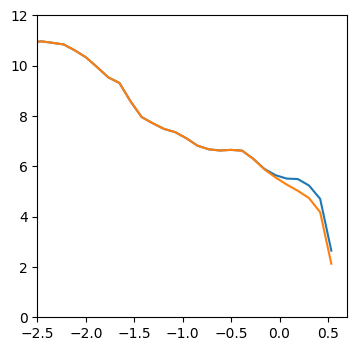

In [20]:
nbs=100
radcap=100
radfloor=None
xmin=1e-10
xmax=25
logX=True
logY=True
xlim=(-2.5,0.7)
ylim=(0,12)


                
bindata=(nbs, xmin, xmax, True)      
mad=MADBins(d2, bindata)
dff=mad.getBinning(d2.lfac-1, 100)
(df, grid)=mad.getInfo()


fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
mad.plot(dff,True,True,ax,xlim,ylim)

/tmp/ipykernel_1784041/179274350.py:43: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normrho) if logY else normrho,label='rho, t=4000')
/tmp/ipykernel_1784041/179274350.py:44: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mid,np.log10(normtr1) if logY else normtr1,label='dtr, t=4000')


,bin,rhomass,tr1mass
0,"[1e-10, 1.3219e-10)",0.000000,0.000000
1,"[1.3219e-10, 1.7475e-10)",0.000000,0.000000
2,"[1.7475e-10, 2.3101e-10)",0.000000,0.000000
3,"[2.3101e-10, 3.0539e-10)",0.000000,0.000000
4,"[3.0539e-10, 4.037e-10)",0.000000,0.000000
...,...,...,...
94,"[24.77076, 32.74549)",16528.966797,3010.167725
95,"[32.74549, 43.28761)",39052.230469,925.410461
96,"[43.28761, 57.22368)",13053.689453,229.410385
97,"[57.22368, 75.64633)",1700.896606,8.762062


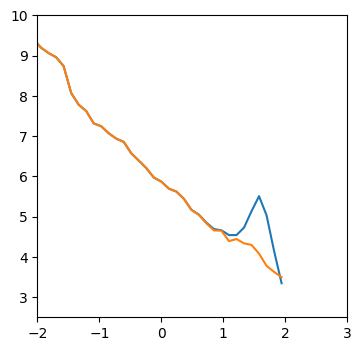

In [19]:
nbs=100
radcap=100
radfloor=None
xmin=1e-10
xmax=100
logX=True
logY=True
xlim=(-2,3)
ylim=(2.5,10)

rsigma=d2.sigma
tsigma=d2.sigma/np.clip(d2.tr1,1e-20,max(d2.tr1))


bindata=(nbs, xmin, xmax, True)
mad2=MADBins(d2, bindata)
rhodf=mad2.getBinning(rsigma,radcap)
tr1df=mad2.getBinning(tsigma,radcap)
fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#mad2.plot(dff2,True,True,ax)
dm=rhodf.rhomass
tm=tr1df.tr1mass
joindf=rhodf[['bin','rhomass']]
joindf['tr1mass']=tm
mad2.plot(joindf,logX,logY,ax,xlim,ylim)
rhodf

In [184]:
nbs=100
radcap=100
radfloor=None
xmin=1e-10
xmax=100
logX=True
logY=True
xlim=(-2,3)
ylim=(2.5,10)

rsigma=d2.sigma
tsigma=d2.sigma/np.clip(d2.tr1,1e-20,max(d2.tr1))


bindata=(nbs, xmin, xmax, True)
mad2=MADBins(d2, bindata)
rhodf=mad2.getBinning(rsigma,radcap)
tr1df=mad2.getBinning(tsigma,radcap)
fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#mad2.plot(dff2,True,True,ax)
dm=rhodf.rhomass
tm=tr1df.tr1mass
joindf=rhodf[['bin','rhomass']]
joindf['tr1mass']=tm
mad2.plot(joindf,logX,logY,ax,xlim,ylim)
rhodf

(3.1622776601683795, 31.622776601683793)

/tmp/ipykernel_1748048/1608285385.py:74: RuntimeWarning: divide by zero encountered in log10
  ax.plot(dmm,np.log10(ydm) if logY else ydm,label='rho, t=4000')
/tmp/ipykernel_1748048/1608285385.py:75: RuntimeWarning: divide by zero encountered in log10
  ax.plot(tmm,np.log10(ydt) if logY else ydt,label='dtr, t=4000')


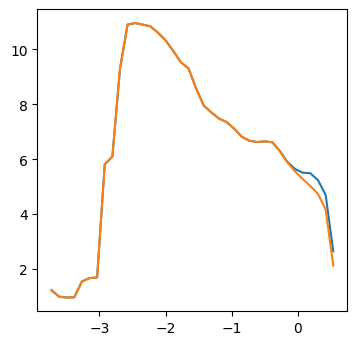

In [27]:
nbs=100
radcap=100
xmin=1e-10
xmax=25
logX=True
logY=True
xlim=(-2.5,0.7)
ylim=(0,12)
binlim=[xmin,xmax]
grid1=np.linspace(np.log10(xmin),np.log10(xmax),nbs) if logX else np.linspace(xmin,xmax,nbs)
grid=[10**item for item in grid1]

def getDenBins2(binvar,data,grid,radcap, radfloor=None):
    cellVol=data.dvol
    cellCent=data.getCenterPoints()
    xCent=cellCent.transpose()[0]
    yCent=cellCent.transpose()[1]
    sqrtg = data.sqrtgamma
    rho=data.rho
    dtr=data.rho*data.tr1
    df=pd.DataFrame({'binvar':binvar,'sqrtg':sqrtg,'rho':rho, 'dtr':dtr,'vol':cellVol,'xcent':xCent,'ycent':yCent, 'rhosqrtg':data.rhosqrtg ,'dtrsqrtg':data.rhosqrtg/rho*dtr})
    df=df[(df.xcent**2+df.ycent**2)<radcap**2]
    df=df[(df.xcent**2+df.ycent**2)>radfloor**2] if radfloor!=None else df 
    df['tmass']=df['dtr']*df['vol']*df['sqrtg']
    df['dmass']=df['rho']*df['vol']*df['sqrtg']
    df['bin']=pd.cut(df['binvar'],grid,right=False, include_lowest=True, precision=5)
    df=df.dropna()
    dm=df.groupby(by='bin')['dmass'].sum()
    tm=df.groupby(by='bin')['tmass'].sum()
    return dm,tm,df


(dm,tm,df)=getDenBins2(d2.lfac-1,d2,grid,radcap)
fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
plot(dm,tm,logX,logY,ax)#,xlim=xlim,ylim=ylim)

/tmp/ipykernel_1477289/4073206773.py:50: RuntimeWarning: divide by zero encountered in true_divide
  sqrtg = data.phi_int*2/abs(data.b1)
/tmp/ipykernel_1477289/4073206773.py:50: RuntimeWarning: invalid value encountered in true_divide
  sqrtg = data.phi_int*2/abs(data.b1)


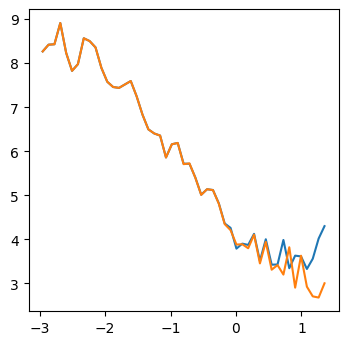

In [199]:
radcap=100
radfloor=80
xmin=1e-3
xmax=25
logX=True
logY=True
binlim=[xmin,xmax]
grid1=np.linspace(np.log10(xmin),np.log10(xmax),50) if logX else np.linspace(xmin,xmax,50)
grid=[10**item for item in grid1]

sigma_den=d2.sigma
dtr=np.clip(d2.dtr1,1e-13,max(d2.dtr1))
sigma_dtr=d2.sigma*d2.d/dtr

(dm,tm,df1,df2)=getDenBins2Var(sigma_den, sigma_dtr,d2,grid,radcap,radfloor)


fig=plt.figure(figsize=(4,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)
plot(dm,tm,logX,logY,ax)
#plot(dm,tm,logX,logY,ax,xlim=(-1.3,0.7),ylim=(-3.5,4))

#ax.plot(x,y,label='rho, t=4000')
#ax.plot(x2,y2,label='dtr, t=4000')
#plt.legend()
#plt.xticks(x)
#plt.xlabel(r'$\log[\sigma]$')
#plt.ylabel(r'$\log[\frac{dm}{d\log(\Gamma-1)}]$')

In [171]:
d2.s1

array([-8.9504123e-02, -1.3440037e-01, -2.3027278e-01, ...,
        6.8521705e-10, -1.5438355e-08, -1.6390363e-08], dtype=float32)

In [536]:
radcap=100
grid1=np.linspace(-7,2,50)
grid=[10**item for item in grid1]
df0=pd.DataFrame({'grid':grid})
df0['bin']=pd.cut(df0['grid'],grid,right=False, include_lowest=True, precision=5)
cellVol=d2.dvol
cellCent=d2.getCenterPoints()
xCent=cellCent.transpose()[0]
yCent=cellCent.transpose()[1]
df=pd.DataFrame({'binvar':d2.sigma,'rho':d2.d, 'dtr':d2.dtr1,'vol':cellVol,'xcent':xCent,'ycent':yCent})
df=df[(df.xcent**2+df.ycent**2)<radcap**2]
df['tmass']=df['dtr']*df['vol']
df['dmass']=df['rho']*df['vol']
df['bin']=pd.cut(df['binvar'],grid,right=False, include_lowest=True, precision=5)
df

,binvar,rho,dtr,vol,xcent,ycent,tmass,dmass,bin
0,100.000000,6.198849e-01,0.000000e+00,0.000011,0.009798,1.197609,0.000000e+00,0.000007,NaN
1,100.000000,6.076409e-01,0.000000e+00,0.000011,0.010003,1.222636,0.000000e+00,0.000007,NaN
2,100.000000,5.714666e-01,0.000000e+00,0.000012,0.010212,1.248185,0.000000e+00,0.000007,NaN
3,100.000000,5.288960e-01,0.000000e+00,0.000013,0.010425,1.274268,0.000000e+00,0.000007,NaN
4,100.000000,4.873353e-01,0.000000e+00,0.000013,0.010643,1.300897,0.000000e+00,0.000006,NaN
...,...,...,...,...,...,...,...,...,...
865181,3.031272,4.370343e-08,2.333077e-10,156572.656250,0.006634,0.014696,3.652961e-05,0.006843,"[2.223, 3.39322)"
865182,3.051084,4.284971e-08,2.874961e-09,166592.765625,0.032776,0.085654,4.789477e-04,0.007138,"[2.223, 3.39322)"
865183,5.204599,4.139901e-08,8.681964e-09,177254.187500,0.233272,0.779468,1.538914e-03,0.007338,"[5.17947, 7.90604)"
865212,3.322796,5.099558e-08,2.793241e-12,101976.828125,2.474734,5.285958,2.848458e-07,0.005200,"[2.223, 3.39322)"


In [66]:
d2.getVarnames()

['d',
 's1',
 's2',
 's3',
 'tau',
 'b1',
 'b2',
 'b3',
 'Ds',
 'dtr1',
 'lfac',
 'xi',
 'B2',
 'divB',
 'gav',
 'rhoav',
 'pav',
 'bav',
 'betainvav',
 'uphiav',
 'ptotav',
 'mdot_int',
 'phi_int',
 'TEMrt',
 'TPAKErt',
 'TENrt',
 'hut',
 'Trphi',
 'j',
 'sigma',
 'betainv',
 'L',
 'Q_r',
 'Q_theta',
 'Q_phi',
 'th_rho',
 'rhosqrtg',
 'dvol',
 'trdiff',
 'trratio']

In [19]:
radmax=100
minbin=1e-7
grid1=np.linspace(np.log10(minbin),np.log10(25),50)
grid=[10**item for item in grid1]
fun=lambda x : '{0:.1f}'.format(x.mid)
df0=pd.DataFrame({'grid':grid})
df0['bin']=pd.cut(df0['grid'],grid,right=False, include_lowest=True, precision=5)
dfd=df0.dropna().copy(deep=True)
dft=df0.dropna().copy(deep=True)
for offset in np.arange(400,401,400):
    data=read.load(offset, file=path+'data',type='vtu', silent=1)
    (dfd0,dft0,dff)=getMassBins(data,grid,radmax)
    dfd[offset]=list(dfd0)
    dft[offset]=list(dft0)
    

/tmp/ipykernel_1192255/498396359.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x),np.log10(y),label='dtr, t=4000')
/tmp/ipykernel_1192255/498396359.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x),np.log10(y2),label='rho, t=4000')


Text(0, 0.5, '$\\log[\\frac{dm}{d\\log(\\Gamma-1)}]$')

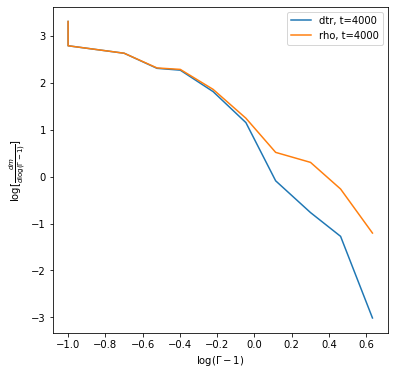

In [20]:
def fun(x): return '{0:.1f}'.format(x.mid)
x=list(pd.to_numeric(dft['bin'].apply(fun)))[:-2]
dfd['interval']=dfd['bin'].apply(lambda x: np.log10(x.right)-np.log10(x.left))
dft['interval']=dft['bin'].apply(lambda x: np.log10(x.right)-np.log10(x.left))
y=list(dft[400]/dft['interval'].astype(float))[:-2]
y2=list(dfd[400]/dfd['interval'].astype(float))[:-2]
plt.figure(figsize=(6,6))
plt.plot(np.log10(x),np.log10(y),label='dtr, t=4000')
plt.plot(np.log10(x),np.log10(y2),label='rho, t=4000')
plt.legend()
#plt.xticks(x)
plt.xlabel(r'$\log(\Gamma - 1)$')
plt.ylabel(r'$\log[\frac{dm}{d\log(\Gamma-1)}]$')

In [336]:
dfd

,grid,bin,400,interval
0,1.000000e-07,"[1e-07, 1.4838e-07)",0.000000,0.171375
1,1.483838e-07,"[1.4838e-07, 2.2018e-07)",0.000000,0.171403
2,2.201776e-07,"[2.2018e-07, 3.2671e-07)",0.000000,0.171385
3,3.267079e-07,"[3.2671e-07, 4.8478e-07)",0.000000,0.171382
4,4.847816e-07,"[4.8478e-07, 7.1934e-07)",0.000000,0.171390
5,7.193374e-07,"[7.1934e-07, 1.0674e-06)",0.000000,0.171393
6,1.067380e-06,"[1.0674e-06, 1.5838e-06)",0.000000,0.171373
7,1.583820e-06,"[1.5838e-06, 2.3501e-06)",0.000000,0.171386
8,2.350132e-06,"[2.3501e-06, 3.4872e-06)",0.000000,0.171391
9,3.487215e-06,"[3.4872e-06, 5.1745e-06)",0.000000,0.171392


In [331]:
grid1=np.linspace(np.log10(1e-7),np.log10(25),100)
grid=[10**item for item in grid1]
fun=lambda x : '{0:.1f}'.format(x.mid)
df0=pd.DataFrame({'grid':grid})
df0['bin']=pd.cut(df0['grid'],grid,right=False, include_lowest=True,precision=5)
(np.log10(grid[4])-np.log10(grid[3]), np.log10(grid[51])-np.log10(grid[50]))
(np.log10(df0.bin[4].right)-np.log10(df0.bin[4].left),np.log10(df0.bin[51].right)-np.log10(df0.bin[51].left))


(0.08483401998389617, 0.08483407245666275)

/tmp/ipykernel_728626/3031927595.py:5: RuntimeWarning: divide by zero encountered in log10
  p1=polyplot(np.log10(d2.lfac-1),d2,xrange=xrng,yrange=yrng, fig=fig, axis=ax, max=1, min=-4, cmap='jet')


plotting range between -4.000000e+00 and 1.000000e+00
xrange = [0.000000e+00,1.000000e+02]     yrange = [-1.000000e+02,1.000000e+02]
colormap = jet; nlevels=256; orientation=vertical
Getting formatted pointlist time=0.000001 sec
time for arranging the data= 0.539343 sec
Execution time = 1.402550 sec


Text(539.8652777777778, 0.5, '$\\log_{10}(\\Gamma$-1)')

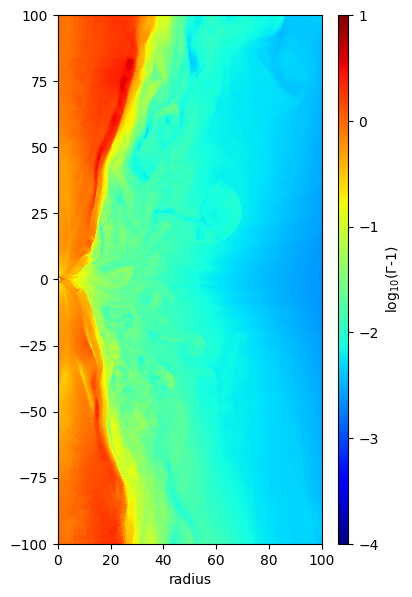

In [249]:
xrng=[0,100]
yrng=[-100,100]
fig=plt.figure(figsize=(7,7),dpi=100)
ax = fig.add_subplot(1, 1, 1)
p1=polyplot(np.log10(d2.lfac-1),d2,xrange=xrng,yrange=yrng, fig=fig, axis=ax, max=1, min=-4, cmap='jet')
p1.ax.set_xlabel('radius')
p1.cbar.ax.set_ylabel(r'$\log_{10}(\Gamma$-1)')

In [869]:
file=open('outmadhres_den','wb')
pickle.dump(dfd,file)
file.close()

In [912]:
file=open('outmadhres_den','rb')
dfd=pickle.load(file)
file.close()

In [59]:
d2=read.load(400, file=path+'data',type='dat', silent=1);

Unknown filetype


AttributeError: 'load' object has no attribute 'datareader'